# In this notebook we use a two stain SEIR model to forecast for future using predefined parameters of a hidden state models ensemble

In [650]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
import joblib

In [651]:
sns.set()
%matplotlib inline

In [652]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [653]:
%autoreload 2

In [654]:
from sir_models.models import SEIRHidden, SEIRHiddenTwoStrains
from sir_models.fitters import HiddenCurveFitter

# Load data

In [655]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])
df.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
0,2020-03-12,21,0,0,0,21,0,21,21.0,0.0,0.0,0.0,21.0,0.0,21.0
1,2020-03-13,26,0,0,0,5,0,26,26.0,0.0,0.0,0.0,5.0,0.0,26.0
2,2020-03-14,35,0,0,0,9,0,35,35.0,0.0,0.0,0.0,9.0,0.0,35.0
3,2020-03-15,35,1,0,0,0,1,34,35.0,1.0,0.0,0.0,0.0,1.0,34.0
4,2020-03-16,53,1,0,0,18,0,52,53.0,1.0,0.0,0.0,18.0,0.0,52.0


In [656]:
date_of_first_strain2_contact = '2021-01-10'
df[df.date == date_of_first_strain2_contact].iloc[0]

date                     2021-01-10 00:00:00
total_infected                        857568
total_recovered                       695106
total_dead                             11950
deaths_per_day                            77
infected_per_day                        4216
recovered_per_day                       7045
infected                              150512
total_infected_ma7              843333.28571
total_recovered_ma7             673614.28571
total_dead_ma7                   11727.28571
deaths_per_day_ma7                  73.85714
infected_per_day_ma7              4655.57143
recovered_per_day_ma7             7026.14286
infected_ma7                    157991.71429
Name: 304, dtype: object

In [657]:
train_df = df[df.date < date_of_first_strain2_contact]

In [658]:
train_df.tail()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
299,2021-01-05,833412,659076,11582,75,4842,6752,162754,819533.85714,639927.71429,11357.57143,74.00000,5044.85714,6240.00000,168248.57143
300,2021-01-06,838554,666282,11652,70,5142,7206,160620,824584.00000,646354.85714,11431.28571,73.71429,5050.14286,6427.14286,166797.85714
301,2021-01-07,843425,673692,11728,76,4871,7410,158005,829392.00000,652972.57143,11505.42857,74.14286,4808.00000,6617.71429,164914.00000
302,2021-01-08,848452,680759,11799,71,5027,7067,155894,834074.28571,659695.00000,11579.57143,74.14286,4682.28571,6722.42857,162799.71429
303,2021-01-09,853352,688061,11873,74,4900,7302,153418,838677.71429,666588.14286,11653.42857,73.85714,4603.42857,6893.14286,160436.14286


# Train predictions

In [659]:
model = joblib.load('seir_hidden_moscow.pkl')

In [660]:
# model.params['t360_q'].value = 0.6

In [661]:
model.params

name,value,initial value,min,max,vary,expression,brute step
population,12000000.0,12000000,-inf,inf,False,,None
sigmoid_r,20.0000000,20,1.00000000,30.0000000,False,,1.00000000
sigmoid_c,0.50000000,0.5,0.00000000,1.00000000,False,,0.10000000
epidemic_started_days_ago,10.0000000,10,1.00000000,90.0000000,False,,10.0000000
r0,4.78139479,4,3.00000000,5.00000000,True,,0.05000000
alpha,0.00640000,0.0064,0.00500000,0.00780000,True,,5.0000e-04
delta,0.49969140,0.3333333333333333,0.07142857,0.50000000,True,,None
gamma,0.11111111,0.1111111111111111,0.07142857,0.14285714,False,,None
rho,0.11111111,0.1111111111111111,-inf,inf,False,gamma,None
incubation_days,2.00123517,3.0,-inf,inf,False,1/delta,None


In [662]:
train_initial_conditions = model.get_initial_conditions(train_df)
train_t = np.arange(len(train_df))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

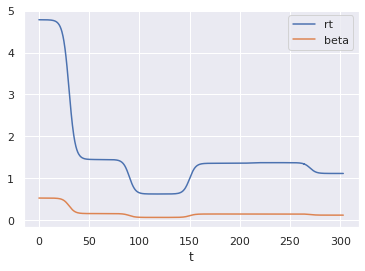

In [663]:
plt.figure()
history.rt.plot()
history.beta.plot()
# plt.plot(np.arange(len(df.reproduction_rate)), df.reproduction_rate, label='Rt from data')
plt.legend()
plt.show()

In [664]:
history.rt.iloc[-1]

1.11747302118911

# Future forecast - one strain

In [665]:
future_dates = pd.date_range(start=date_of_first_strain2_contact, periods=365//2)
future_t = np.max(train_t) + 1 + np.arange(len(future_dates))

assert len(future_dates) == len(future_t)

In [666]:
future_dates

DatetimeIndex(['2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-19',
               ...
               '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-10'],
              dtype='datetime64[ns]', length=182, freq='D')

In [667]:
train_t[-10:], future_t[:10]

(array([294, 295, 296, 297, 298, 299, 300, 301, 302, 303]),
 array([304, 305, 306, 307, 308, 309, 310, 311, 312, 313]))

In [668]:
future_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [669]:
(future_S, future_E, future_I, future_Iv, future_R, future_Rv, future_D, future_Dv), history = model.predict(future_t,
                                                                                                             future_initial_conds)
(future_new_exposed,
 future_new_infected_invisible, future_new_infected_visible,
 future_new_recovered_invisible,
 future_new_recovered_visible,
 future_new_dead_invisible, future_new_dead_visible) = model.compute_daily_values(future_S, future_E, future_I,
                                                                                  future_Iv, future_R, future_Rv,
                                                                                  future_D, future_Dv)

In [670]:
future_daily_df = pd.DataFrame(
    {
        'date': future_dates[1:],
        'new_exposed': future_new_exposed,
        'new_infected_invisible': future_new_infected_invisible,
        'new_infected_visible': future_new_infected_visible,
        'new_recovered_invisible': future_new_recovered_invisible,
        'new_recovered_visible': future_new_recovered_visible,
        'new_dead_invisible': future_new_dead_invisible,
        'new_dead_visible': future_new_dead_visible
    },
    index=future_dates[1:])

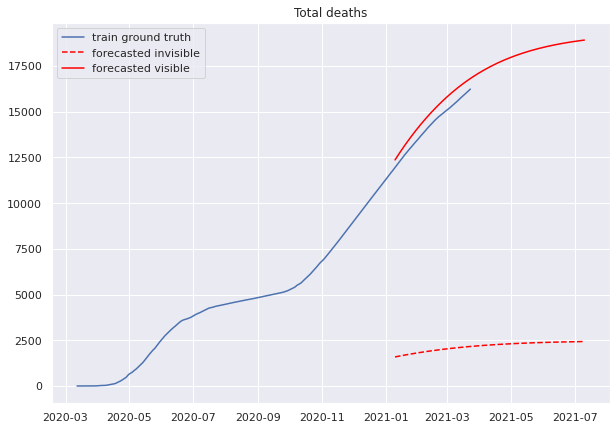

In [671]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df['total_dead'], label='train ground truth')
plt.plot(future_dates, future_D, label='forecasted invisible', color='red', linestyle='dashed')
plt.plot(future_dates, future_Dv, label='forecasted visible', color='red')
plt.legend()
plt.title('Total deaths')
plt.show()

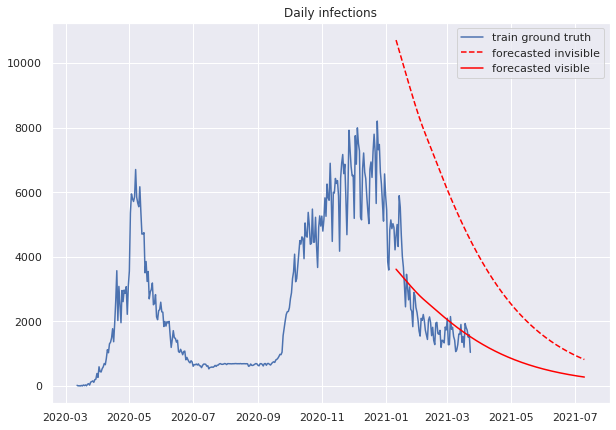

In [672]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df['infected_per_day'], label='train ground truth')

plt.plot(future_daily_df.new_infected_invisible, label='forecasted invisible', color='red', linestyle='dashed')
plt.plot(future_daily_df.new_infected_visible, label='forecasted visible', color='red')
plt.legend()
plt.title('Daily infections')
plt.show()

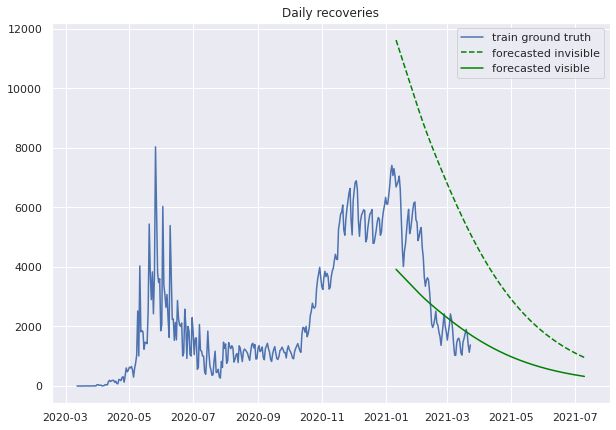

In [673]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df['recovered_per_day'], label='train ground truth')

plt.plot(future_daily_df.new_recovered_invisible, label='forecasted invisible', color='green', linestyle='dashed')
plt.plot(future_daily_df.new_recovered_visible, label='forecasted visible', color='green')
plt.legend()
plt.title('Daily recoveries')
plt.show()

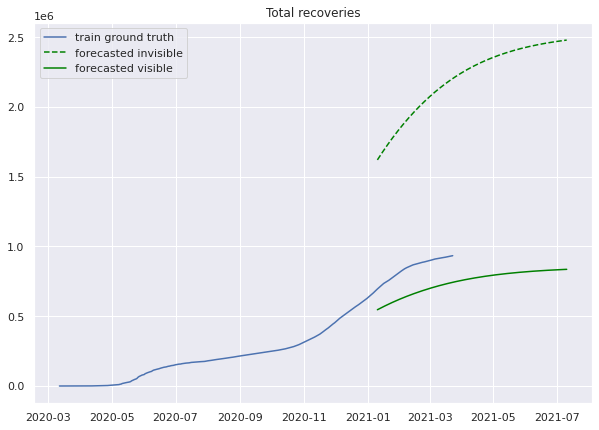

In [674]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df['total_recovered'], label='train ground truth')

plt.plot(future_dates, future_R, label='forecasted invisible', color='green', linestyle='dashed')
plt.plot(future_dates, future_Rv, label='forecasted visible', color='green')
plt.legend()
plt.title('Total recoveries')
plt.show()

# Extrapolate with two stains

In [675]:
strain2_model = SEIRHiddenTwoStrains.from_strain_one_model(model)

In [676]:
strain2_model.params['beta2_mult']

<Parameter 'beta2_mult', value=1.5 (fixed), bounds=[1:2]>

In [677]:
# 1% infected with new strain

new_stain_ratio = 0.01

E2_0 = E[-1] * new_stain_ratio
E1_0 = E[-1] *  (1-new_stain_ratio)
Iv2_0 = Iv[-1] * new_stain_ratio
Iv1_0 = Iv[-1] *  (1-new_stain_ratio)
I2_0 = I[-1] * new_stain_ratio
I1_0 = I[-1] *  (1-new_stain_ratio)

future_initial_conds_two_strain = (S[-1],
                                   E1_0,
                                   I1_0,
                                   Iv1_0,
                                   E2_0,
                                   I2_0,
                                   Iv2_0,
                                   R[-1],
                                   Rv[-1],
                                   D[-1],
                                   Dv[-1])
I2_0, Iv2_0

(1057.161607694094, 356.54276865149063)

In [678]:
(future_S, future_E1, future_I1, future_Iv1, future_E2, future_I2, future_Iv2, future_R, future_Rv, future_D,
 future_Dv), future_history = strain2_model.predict(future_t,
                                             future_initial_conds_two_strain)
(future_new_exposed,
 future_new_infected_invisible, future_new_infected_visible,
 future_new_recovered_invisible,
 future_new_recovered_visible,
 future_new_dead_invisible, future_new_dead_visible) = strain2_model.compute_daily_values(future_S, future_E1,
                                                                                          future_I1, future_Iv1,
                                                                                          future_E2, future_I2,
                                                                                          future_Iv2, future_R,
                                                                                          future_Rv, future_D,
                                                                                          future_Dv)

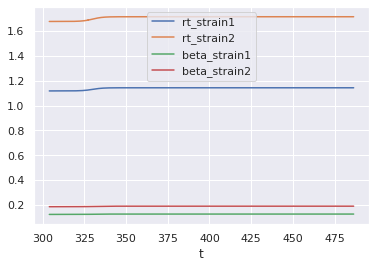

In [679]:
plt.figure()
future_history.rt_strain1.plot()
future_history.rt_strain2.plot()

future_history.beta_strain1.plot()
future_history.beta_strain2.plot()
plt.legend()
plt.show()

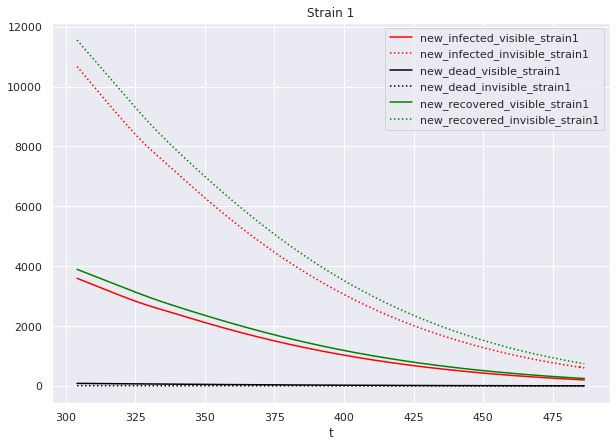

In [680]:
plt.figure(figsize=(10,7))
future_history.new_infected_visible_strain1.plot(color='red')
future_history.new_infected_invisible_strain1.plot(color='red', linestyle=':')
future_history.new_dead_visible_strain1.plot(color='black')
future_history.new_dead_invisible_strain1.plot(color='black', linestyle=':')
future_history.new_recovered_visible_strain1.plot(color='green')
future_history.new_recovered_invisible_strain1.plot(color='green', linestyle=':')
plt.title('Strain 1')
plt.legend()

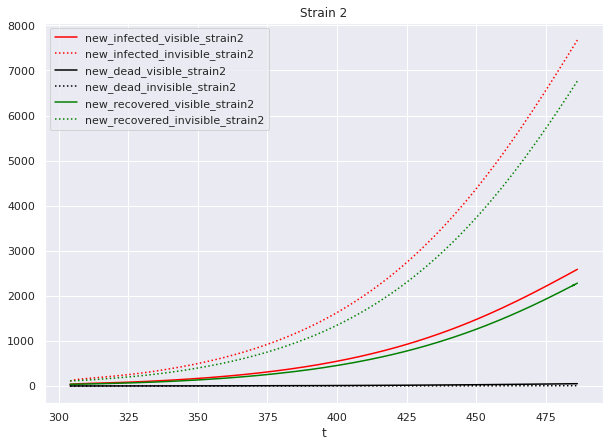

In [681]:
plt.figure(figsize=(10,7))
future_history.new_infected_visible_strain2.plot(color='red')
future_history.new_infected_invisible_strain2.plot(color='red', linestyle=':')
future_history.new_dead_visible_strain2.plot(color='black')
future_history.new_dead_invisible_strain2.plot(color='black', linestyle=':')
future_history.new_recovered_visible_strain2.plot(color='green')
future_history.new_recovered_invisible_strain2.plot(color='green', linestyle=':')
plt.title('Strain 2')
plt.legend()

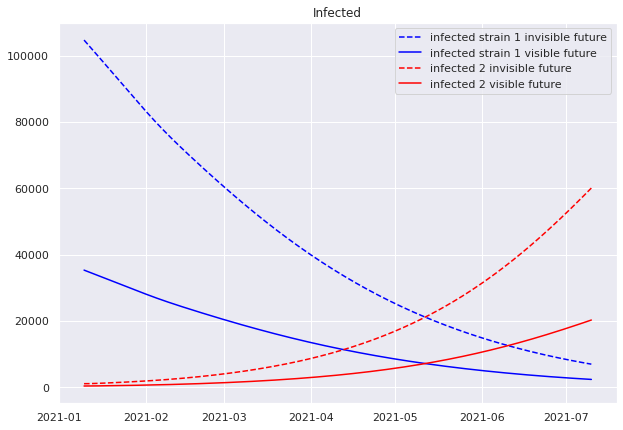

In [682]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1, label='infected strain 1 invisible future',  color='blue', linestyle='--')
plt.plot(future_dates, future_Iv1, label='infected strain 1 visible future', color='blue')
plt.plot(future_dates, future_I2, label='infected 2 invisible future', color='red', linestyle='--')
plt.plot(future_dates, future_Iv2, label='infected 2 visible future', color='red')

plt.legend()
plt.title('Infected')
plt.show()

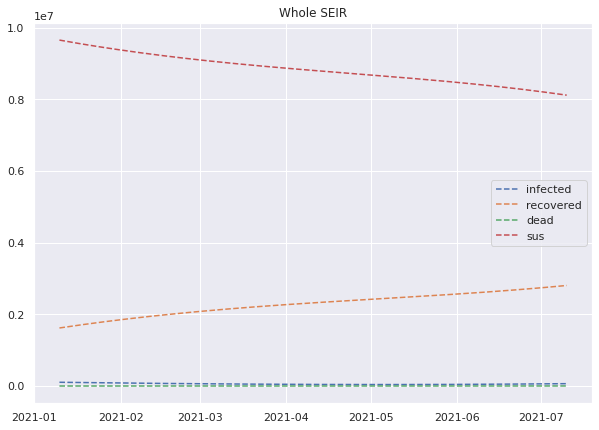

In [683]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1 + future_I2, label='infected', linestyle='--')
plt.plot(future_dates, future_R, label='recovered', linestyle='--')
plt.plot(future_dates, future_D, label='dead', linestyle='--')
plt.plot(future_dates, future_S, label='sus', linestyle='--')
plt.legend()
plt.title('Whole SEIR')
plt.show()

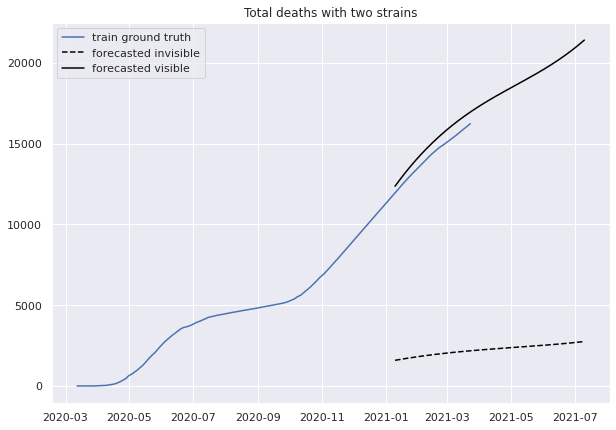

In [684]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df['total_dead'], label='train ground truth')
plt.plot(future_dates, future_D, label='forecasted invisible', color='black', linestyle='dashed')
plt.plot(future_dates, future_Dv, label='forecasted visible', color='black')
plt.legend()
plt.title('Total deaths with two strains')
plt.show()